# Neuronal Functional Connectivity Estimation

In [1]:
from copy import deepcopy
from collections import defaultdict

import matplotlib.pyplot as plt
import numpy as np
import scipy.io
from sklearn.decomposition import PCA
from scipy import linalg
import seaborn as sns
import time

%matplotlib inline
%load_ext autoreload
%autoreload 2

import evals
import globals as glb
import utils
import plot_utils
from data_loader import SpontaneousRecordingData
from data_loader import GratingStimuliRecordingData # Recording with Grating Stimuli
from data_loader import VisualStimuliRecordingData # Recording with Image Stimuli

from NearestPSD import shrinking, nearest_correlation
from data_sampler import MissingTraceSampler, PartialSpontRecordingData
import warnings
warnings.filterwarnings('ignore')
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from math import ceil


The datasets we use for this project is published by Carsen Stringer at https://janelia.figshare.com/articles/dataset/Recordings_of_10k_neurons_in_V1_during_drifting_gratings/6214019  
  
<font color=brown> To run the following code, please make sure you have the dataset downloaded locally and set its local path to the 'DATA_DIR' variable below.</font>

# Load Spontaneous Activity Datasets
Change the following DATA_DIR to your local data directory!

In [2]:
DATA_DIR = "../Data/"
spont_mat = scipy.io.loadmat(DATA_DIR + "dbspont.mat").get("db")[0]  # 9 datasets of recordings

In [3]:
# Session 1: Around 120 mins
SIDX = 0
spont0_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], spont_mat[SIDX][glb.REC_DATE][0]])
spont_dataset0 = SpontaneousRecordingData(data_fp=spont0_fp)

Removing 1 all-zero columns


In [4]:
# Basic statistics about the dataset
spont_dataset0.display_field_shapes()

neuron counts: 11983
layer counts: 9
Layer 0: 1131 neurons
Layer 1: 1183 neurons
Layer 2: 1218 neurons
Layer 3: 1321 neurons
Layer 4: 1415 neurons
Layer 5: 1471 neurons
Layer 6: 1418 neurons
Layer 7: 1440 neurons
Layer 8: 1386 neurons
timestamp counts 21054
running speed (21054, 1)
face motion mask (240, 320, 1000)
face motion svd (21054, 1000)
avg frame (240, 320)
pupil area (21054, 1)
pupil com (21054, 2)
eye motion svd (21054, 500)
whisker motion mask (216, 304, 500)
whisker motion SVD (21054, 500)


# Load all 9 datasets
NOTE: Change the DATA_DIR to your local path of the data directory!
  
While loading the datasets, the loader automatically removes the ill-formatted entries.

In [5]:
# # Input data matrices
# SpontData = dict()

# for SIDX in range(9):
#     # Load Data
#     spont_fp = DATA_DIR + "_".join(["spont", spont_mat[SIDX][glb.SESSION_NAME][0], 
#                                     spont_mat[SIDX][glb.REC_DATE][0]])
#     spont_dataset = SpontaneousRecordingData(data_fp=spont_fp)
#     SpontData[SIDX] = spont_dataset
#     print(SIDX, spont_dataset.fsp.shape)
    

### Use QuicGraphLasso as the Ground Truth

In [6]:
# subset the dataset in all three dimensions
# - select layer 0, 2, 3
# - consider only timestamp from 100 to 1000
# - consider horizontal region of ratio 0.1 - 0.3 w.r.t. the original plane
partial_spont0 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[0,1,2,3,4], start_timepoint=100, end_timepoint=1100, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)


In [7]:
partial_spont0.run_speed.shape

(1000, 1)

In [8]:
partial_spont0.fsp.shape

(253, 1000)

In [64]:
from sklearn.covariance import graphical_lasso
from inverse_covariance import QuicGraphLasso
from statsmodels.stats.moment_helpers import cov2corr, corr2cov

# With Normalizing
def get_prec_skggm(spont_data_fsp, display=False):
    prec_skggm = get_prec_skggm_original(spont_data_fsp, display)
    return cov2corr(prec_skggm)#normalize


# Without Normalizing
def get_prec_skggm_original(spont_data_fsp, display=False):
#     prec_sample = spont_data.sample_precision_matrix(display=display)


    skggm_model = QuicGraphLasso(
    lam=0.1,  # Graphical lasso penalty (scalar or matrix)
    mode='default',               # 'default': single estimate
    )
    skggm_model.fit(spont_data_fsp.T) 

    prec_skggm = skggm_model.precision_
    if display:
        title = "skggm precision matrix"
        plt.title(title, fontsize=16, fontweight="bold")
        plt.imshow(prec_skggm, cmap=plt.cm.get_cmap("RdBu_r"))
        plt.xticks(())
        plt.yticks(())
        
    return prec_skggm

In [10]:
prec_skggm0 = get_prec_skggm(partial_spont0.fsp, display=False)

### Get features X (fsp pairs) and labels y (precision matrix entries)

In [11]:
partial_spont0.fsp.shape

(253, 1000)

In [12]:
def prepare_data(spont_data_fsp):
    prec_skggm = get_prec_skggm(spont_data_fsp, display=False)
    # print("fsp has shape (neuron count, timestamp count) = ", spont_data_fsp.shape)
    X = []
    y = [] 
    for i,f1 in enumerate(spont_data_fsp):
        for j,f2 in enumerate(spont_data_fsp):
            X.append(np.concatenate((f1,f2)))
            y.append(prec_skggm[i,j])
    X = np.array(X)
    y = np.array(y)
    return X,y 

def split_data(X, y):
    #train:test:validation = 7:2:1
    X_train, X_test0, y_train, y_test0 = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)
    X_test, X_validation, y_test, y_validation = train_test_split(X_test0, y_test0, test_size=0.333, random_state=42, shuffle=True)

    return X_train, X_test, X_validation, y_train, y_test, y_validation

X,y = prepare_data(partial_spont0.fsp)
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("X_validation.shape = ", X_validation.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)
print("y_validation.shape = ", y_validation.shape)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)


In [13]:
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
])


model.compile(optimizer='adam',     
              loss= 'mean_squared_error',  
              metrics=['mse'])

model.fit(X_train, y_train, epochs=3, validation_data=(X_validation, y_validation))

print("\nEvaluation:")
print('test MSE:', model.evaluate(X_test, y_test))

Epoch 1/3
1401/1401 [==============================] - 45s 31ms/step - loss: 0.3008 - mse: 0.3008 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/3
1401/1401 [==============================] - 47s 34ms/step - loss: 0.0041 - mse: 0.0041 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/3
1401/1401 [==============================] - 48s 34ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0041 - val_mse: 0.0041

Evaluation:
401/401 [==============================] - 3s 8ms/step - loss: 0.0038 - mse: 0.0038
test MSE: [0.0037700380198657513, 0.0037700380198657513]


### a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen

In [14]:
partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[6,7], start_timepoint=100, end_timepoint=1100, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)

X,y = prepare_data(partial_spont1.fsp)
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X, y))


X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 7s 10ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006659532897174358, 0.006659532897174358]


### b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen

In [15]:
partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[2,3], start_timepoint=2000, end_timepoint=3000, 
                                           x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)

X,y = prepare_data(partial_spont1.fsp)
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X, y))


X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 4s 11ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009785538539290428, 0.009785538539290428]


### c.Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen

In [16]:
partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[2,3], start_timepoint=100, end_timepoint=1100, 
                                           x_range=(0.4, 0.6), y_range=(0.4, 0.6), ratio=True)

X,y = prepare_data(partial_spont1.fsp)
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X, y))


X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 6s 12ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007459963671863079, 0.007459963671863079]


### d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen

In [17]:
partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[7,8], start_timepoint=2000, end_timepoint=3000, 
                                           x_range=(0.4, 0.6), y_range=(0.4, 0.6), ratio=True)

X,y = prepare_data(partial_spont1.fsp)
print("X.shape = ", X.shape)
print("y.shape = ", y.shape)


print("Evaluation on unseen neurons:")
print('test MSE:', model.evaluate(X, y))


X.shape =  (13924, 2000)
y.shape =  (13924,)
Evaluation on unseen neurons:
436/436 [==============================] - 5s 12ms/step - loss: 0.0084 - mse: 0.0084
test MSE: [0.008436029776930809, 0.008436029776930809]


### We use two approaches to obtain the covariances of neurons. Approach 1: fill the missing entries in the fsp of each neuron by 0, mean, or median. Then use Neural Network. Approach 2: use Neural Network to predict the missing entries in the sample covariance matrix. Then use graphical lasso.


# Approach 1 - A. Sample Missing Data by Layers (continuous)

## 1. Fill missing entries with 0

In [18]:
sampler = MissingTraceSampler()

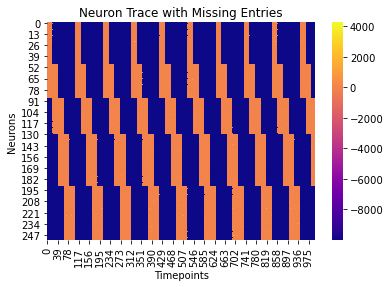

(253, 1000)


In [19]:
missing_fsp_cont = sampler.missing_fsp_consecutive_layers(dataset=partial_spont0, sim_timestamps=21, sim_layer_size=2, 
                                                          layer_stride=1, display=True)

print(missing_fsp_cont.shape)
missing_fsp_cont_filled_0 = pd.DataFrame(missing_fsp_cont).fillna(0)

In [20]:
# missing_fsp_corr = cov2corr(pd.DataFrame(missing_fsp_cont).transpose().cov().fillna(0))
# shrinking.checkPD(missing_fsp_corr) # Result: Not PD

# missing_fsp_corr_near = nearest_correlation.nearcorr(missing_fsp_corr)
# shrinking.checkPD(missing_fsp_corr_near) # Result: Not PD

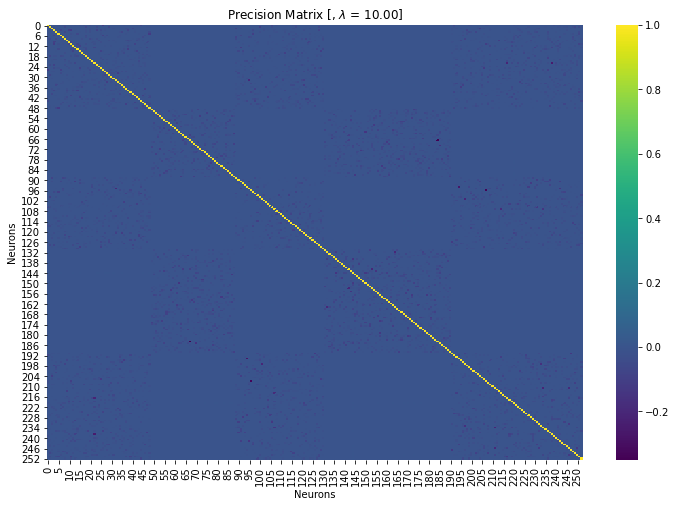

<Figure size 864x576 with 0 Axes>

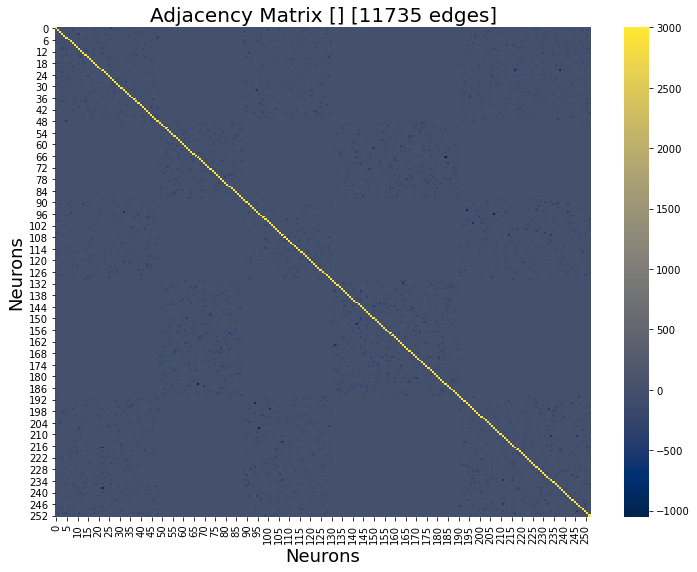

In [61]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_0, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [21]:
def train_NN(missing_fsp_cont_filled):
    missing_fsp_cont_filled = np.array(missing_fsp_cont_filled)
    X,y = prepare_data(missing_fsp_cont_filled)
    X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(X, y)
    print("X_train.shape = ", X_train.shape)
    print("X_test.shape = ", X_test.shape)
    print("X_validation.shape = ", X_validation.shape)

    print("\ny_train.shape = ", y_train.shape)
    print("y_test.shape = ", y_test.shape)
    print("y_validation.shape = ", y_validation.shape)
    
    model_missing = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(16, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1)
    ])


    model_missing.compile(optimizer='adam',     
                  loss= 'mean_squared_error',  
                  metrics=['mse'])

    model_missing.fit(X_train, y_train, epochs=3, validation_data=(X_validation, y_validation))

    print("\nEvaluation:")
    print('test MSE:', model_missing.evaluate(X_test, y_test))
    
    return model_missing

In [22]:
model_missing_0 = train_NN(missing_fsp_cont_filled_0)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 41s 29ms/step - loss: 10.8449 - mse: 10.8449 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 2/3
1401/1401 [==============================] - 44s 31ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/3
1401/1401 [==============================] - 36s 26ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042

Evaluation:
401/401 [==============================] - 4s 11ms/step - loss: 0.0040 - mse: 0.0040
test MSE: [0.003965943586081266, 0.003965943586081266]


In [23]:
# a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
# b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
# c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
# d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen

def predict_unseen_neurons(model):
    print("a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen")
    partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[6,7], start_timepoint=100, end_timepoint=1100, 
                                               x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)
    X,y = prepare_data(partial_spont1.fsp)
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Evaluation on unseen neurons:")
    print('test MSE:', model.evaluate(X, y))



    print("\n\nb. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen")
    partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[2,3], start_timepoint=2000, end_timepoint=3000, 
                                               x_range=(0.1, 0.3), y_range=(0.1, 0.3), ratio=True)
    X,y = prepare_data(partial_spont1.fsp)
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Evaluation on unseen neurons:")
    print('test MSE:', model.evaluate(X, y))



    print("\n\nc. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen")
    partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[2,3], start_timepoint=100, end_timepoint=1100, 
                                               x_range=(0.4, 0.6), y_range=(0.4, 0.6), ratio=True)
    X,y = prepare_data(partial_spont1.fsp)
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Evaluation on unseen neurons:")
    print('test MSE:', model.evaluate(X, y))



    print("\n\nd. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen")
    partial_spont1 = PartialSpontRecordingData(dataset=spont_dataset0, layers=[7,8], start_timepoint=2000, end_timepoint=3000, 
                                               x_range=(0.4, 0.6), y_range=(0.4, 0.6), ratio=True)
    X,y = prepare_data(partial_spont1.fsp)
    print("X.shape = ", X.shape)
    print("y.shape = ", y.shape)
    print("Evaluation on unseen neurons:")
    print('test MSE:', model.evaluate(X, y))


In [24]:
predict_unseen_neurons(model_missing_0)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 7s 10ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006675142329186201, 0.006675142329186201]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 3s 10ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009817508049309254, 0.009817508049309254]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 5s 9ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007480899337679148, 0.007480899337679148]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shape =

#### Note: 'missing_fsp_cont' is the missing version of 'partial_spont0'. We compared the performances (prediction on unseen neurons) of the NN model trained on 'partial_spont0' and the NN model trained on 'missing_fsp_cont_filled'. From above, we see two models have very similar performances.



## 2. For each neuron, fill missing entries with mean.

In [25]:
df = pd.DataFrame(missing_fsp_cont.T)
missing_fsp_cont_filled_mean = np.array(df.fillna(df.mean()).transpose())
print(missing_fsp_cont_filled_mean.shape)


(253, 1000)


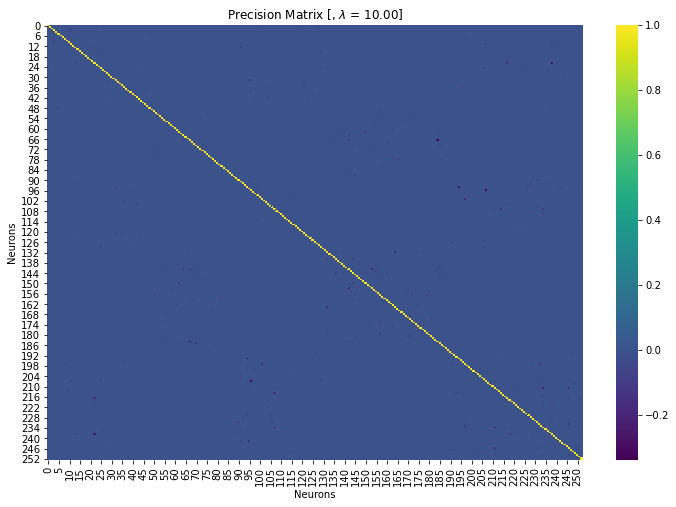

<Figure size 864x576 with 0 Axes>

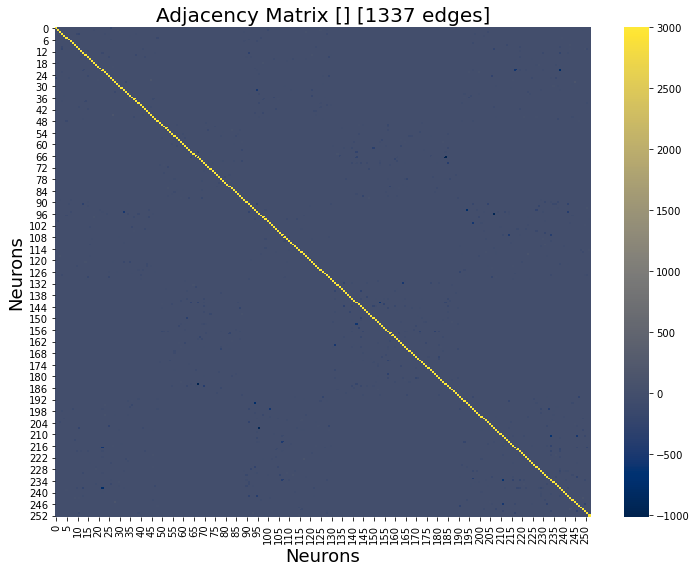

In [67]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_mean, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [26]:
model_missing_mean = train_NN(missing_fsp_cont_filled_mean)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 43s 31ms/step - loss: 0.8832 - mse: 0.8832 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/3
1401/1401 [==============================] - 38s 27ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/3
1401/1401 [==============================] - 38s 27ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0041 - val_mse: 0.0041

Evaluation:
401/401 [==============================] - 4s 11ms/step - loss: 0.0038 - mse: 0.0038
test MSE: [0.0038042375817894936, 0.0038042375817894936]


In [27]:
predict_unseen_neurons(model_missing_mean)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 6s 9ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006671711336821318, 0.006671711336821318]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 3s 9ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009811317548155785, 0.009811317548155785]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 5s 9ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007476561702787876, 0.007476561702787876]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shape =  

## 3. For each neuron, fill missing entries with median.

In [28]:
df = pd.DataFrame(missing_fsp_cont.T)
missing_fsp_cont_filled_median = np.array(df.fillna(df.median()).transpose())
print(missing_fsp_cont_filled_median.shape)


(253, 1000)


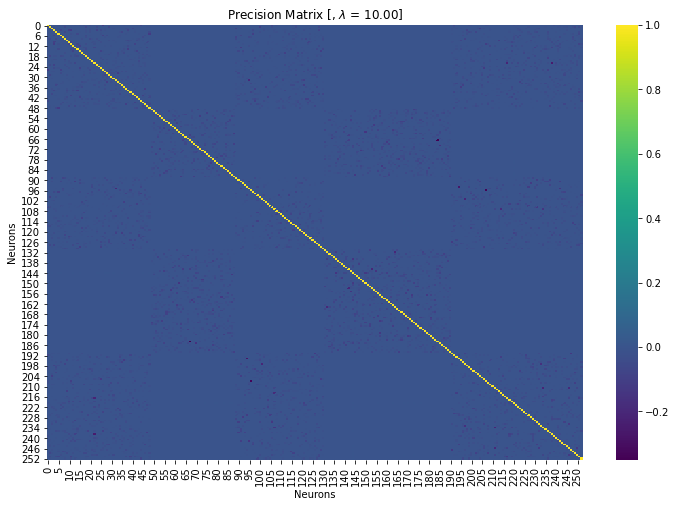

<Figure size 864x576 with 0 Axes>

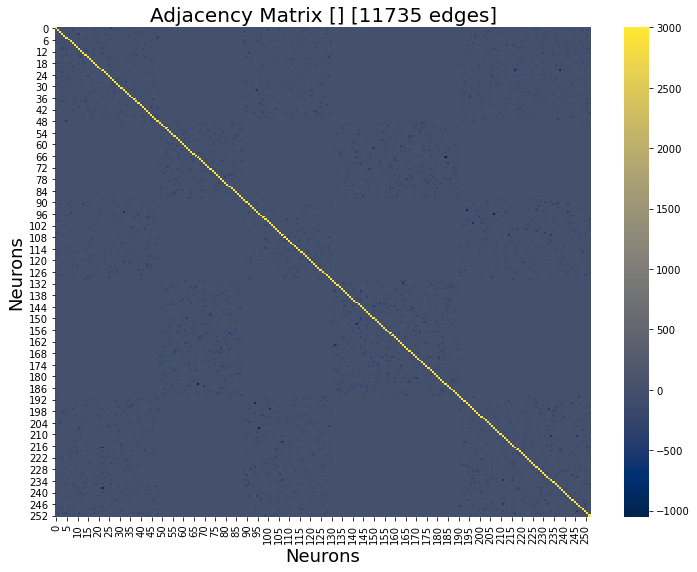

In [63]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_median, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [29]:
model_missing_median = train_NN(missing_fsp_cont_filled_median)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 36s 26ms/step - loss: 0.1063 - mse: 0.1063 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/3
1401/1401 [==============================] - 35s 25ms/step - loss: 0.0044 - mse: 0.0044 - val_loss: 0.0043 - val_mse: 0.0043
Epoch 3/3
1401/1401 [==============================] - 34s 24ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0042 - val_mse: 0.0042

Evaluation:
401/401 [==============================] - 4s 9ms/step - loss: 0.0040 - mse: 0.0040
test MSE: [0.003967261407524347, 0.003967261407524347]


In [30]:
predict_unseen_neurons(model_missing_median)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 6s 8ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006700295954942703, 0.006700295954942703]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 3s 8ms/step - loss: 0.0099 - mse: 0.0099
test MSE: [0.009858179837465286, 0.009858179837465286]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 5s 8ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007511090487241745, 0.007511090487241745]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shape =  

# Approach 1 - B. Sample Missing Data by Layers (interleaving)

## 1. Fill missing entries with 0

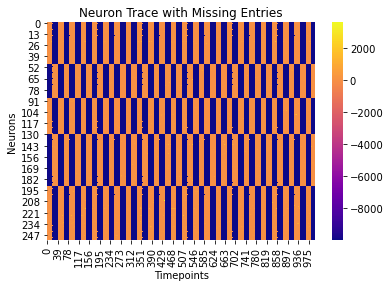

(253, 1000)


In [31]:
sampler = MissingTraceSampler()

missing_fsp_cont = sampler.missing_fsp_interleaving_layers(dataset=partial_spont0, sim_timestamps=21, 
                                                           sim_layer_size=3, display=True)

print(missing_fsp_cont.shape)
missing_fsp_cont_filled_0 = pd.DataFrame(missing_fsp_cont).fillna(0)

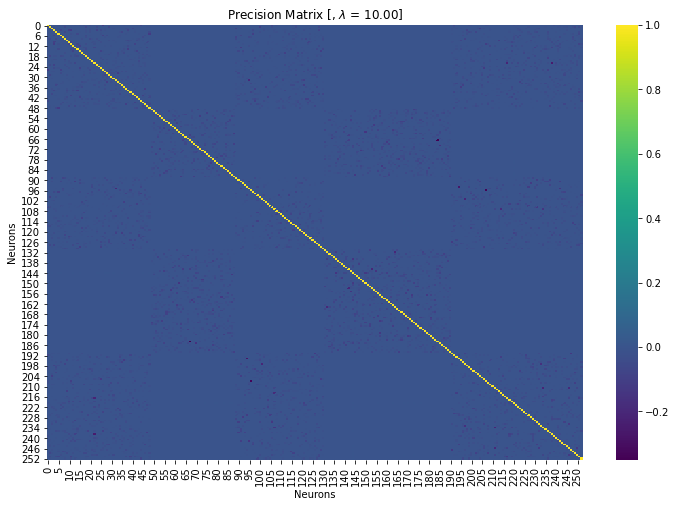

<Figure size 864x576 with 0 Axes>

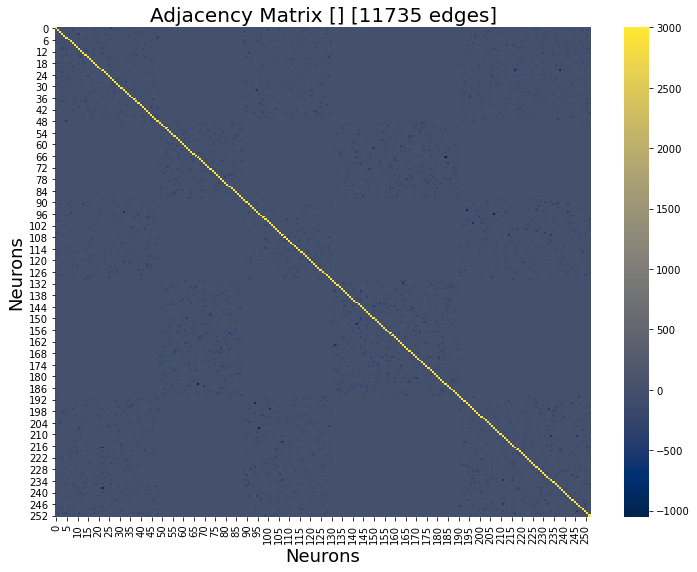

In [68]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_0, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [32]:
model_missing_0 = train_NN(missing_fsp_cont_filled_0)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 40s 27ms/step - loss: 7.3700 - mse: 7.3700 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/3
1401/1401 [==============================] - 42s 30ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/3
1401/1401 [==============================] - 40s 29ms/step - loss: 0.0039 - mse: 0.0039 - val_loss: 0.0042 - val_mse: 0.0042

Evaluation:
401/401 [==============================] - 5s 12ms/step - loss: 0.0039 - mse: 0.0039
test MSE: [0.003925838507711887, 0.003925838507711887]


In [33]:
predict_unseen_neurons(model_missing_0)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 5s 7ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.0066796401515603065, 0.0066796401515603065]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 2s 7ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009825361892580986, 0.009825361892580986]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 4s 7ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007486487273126841, 0.007486487273126841]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shape =

## 2. For each neuron, fill missing entries with mean.

In [34]:
df = pd.DataFrame(missing_fsp_cont.T)
missing_fsp_cont_filled_mean = np.array(df.fillna(df.mean()).transpose())
print(missing_fsp_cont_filled_mean.shape)


(253, 1000)


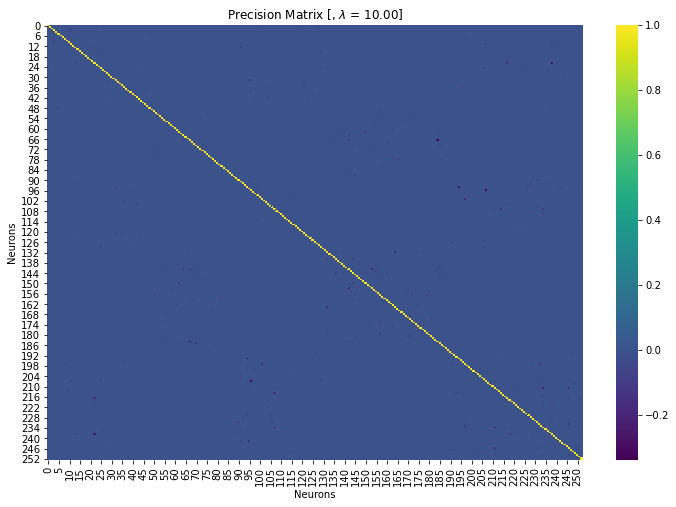

<Figure size 864x576 with 0 Axes>

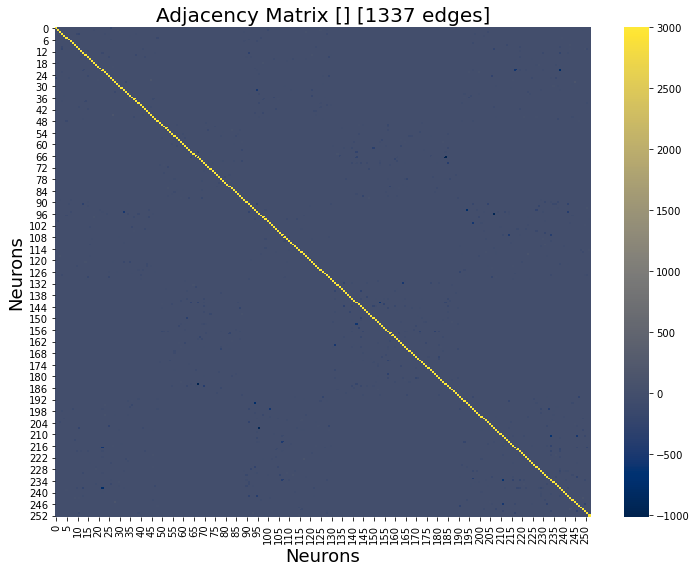

In [69]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_mean, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [35]:
model_missing_mean = train_NN(missing_fsp_cont_filled_mean)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 49s 35ms/step - loss: 2.3702 - mse: 2.3702 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 2/3
1401/1401 [==============================] - 51s 37ms/step - loss: 0.0038 - mse: 0.0038 - val_loss: 0.0041 - val_mse: 0.0041
Epoch 3/3
1401/1401 [==============================] - 42s 30ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0041 - val_mse: 0.0041

Evaluation:
401/401 [==============================] - 4s 9ms/step - loss: 0.0038 - mse: 0.0038
test MSE: [0.0037766466848552227, 0.0037766466848552227]


In [36]:
predict_unseen_neurons(model_missing_mean)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 8s 12ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006659998558461666, 0.006659998558461666]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 5s 16ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009786690585315228, 0.009786690585315228]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 6s 10ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.0074607012793421745, 0.0074607012793421745]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shap

## 3. For each neuron, fill missing entries with median.

In [37]:
df = pd.DataFrame(missing_fsp_cont.T)
missing_fsp_cont_filled_median = np.array(df.fillna(df.median()).transpose())
print(missing_fsp_cont_filled_median.shape)

(253, 1000)


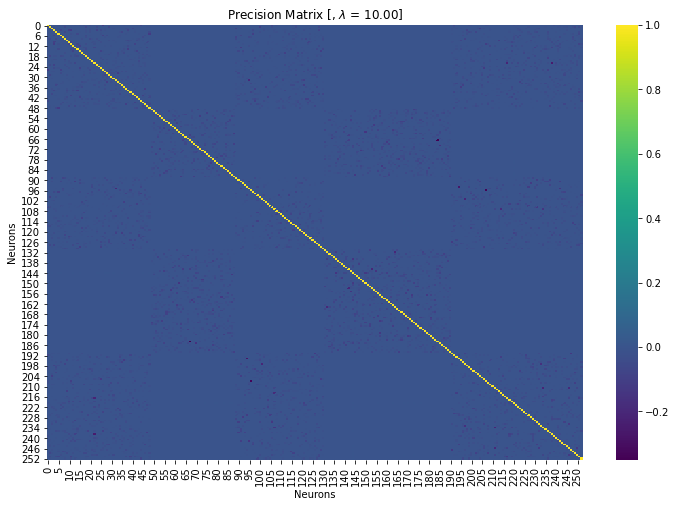

<Figure size 864x576 with 0 Axes>

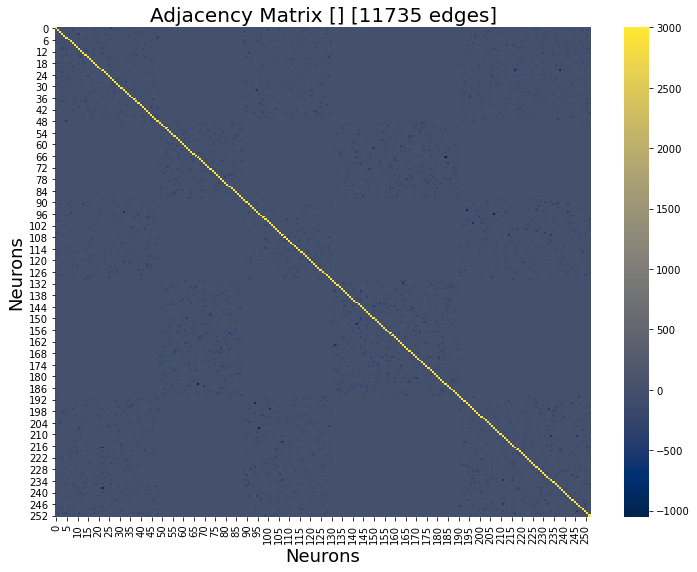

In [70]:
prec_skggm = get_prec_skggm(missing_fsp_cont_filled_median, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm)

In [38]:
model_missing_median = train_NN(missing_fsp_cont_filled_median)

X_train.shape =  (44806, 2000)
X_test.shape =  (12808, 2000)
X_validation.shape =  (6395, 2000)

y_train.shape =  (44806,)
y_test.shape =  (12808,)
y_validation.shape =  (6395,)
Epoch 1/3
1401/1401 [==============================] - 41s 28ms/step - loss: 12.2627 - mse: 12.2627 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 2/3
1401/1401 [==============================] - 35s 25ms/step - loss: 0.0040 - mse: 0.0040 - val_loss: 0.0042 - val_mse: 0.0042
Epoch 3/3
1401/1401 [==============================] - 35s 25ms/step - loss: 0.0042 - mse: 0.0042 - val_loss: 0.0042 - val_mse: 0.0042

Evaluation:
401/401 [==============================] - 3s 8ms/step - loss: 0.0039 - mse: 0.0039
test MSE: [0.003925695084035397, 0.003925695084035397]


In [39]:
predict_unseen_neurons(model_missing_median)

a. Predict on unseen neurons - Layer: unseen; TimePeriod: seen; xyRange: seen
X.shape =  (22801, 2000)
y.shape =  (22801,)
Evaluation on unseen neurons:
713/713 [==============================] - 6s 8ms/step - loss: 0.0067 - mse: 0.0067
test MSE: [0.006681434810161591, 0.006681434810161591]


b. Predict on unseen neurons - Layer: seen; TimePeriod: unseen; xyRange: seen
X.shape =  (10404, 2000)
y.shape =  (10404,)
Evaluation on unseen neurons:
326/326 [==============================] - 3s 8ms/step - loss: 0.0098 - mse: 0.0098
test MSE: [0.009828313253819942, 0.009828313253819942]


c. Predict on unseen neurons - Layer: seen; TimePeriod: seen; xyRange: unseen
X.shape =  (17956, 2000)
y.shape =  (17956,)
Evaluation on unseen neurons:
562/562 [==============================] - 6s 11ms/step - loss: 0.0075 - mse: 0.0075
test MSE: [0.007488650269806385, 0.007488650269806385]


d. Predict on unseen neurons - Layer: unseen; TimePeriod: unseen; xyRange: unseen
X.shape =  (13924, 2000)
y.shape = 

# Approach 2 - A. Sample Missing Data by Layers (continuous)


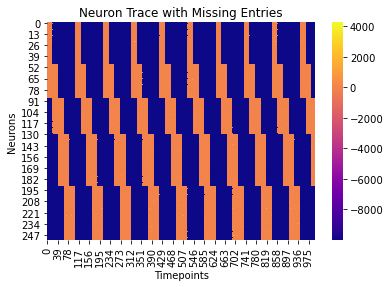

(253, 1000)


array([[36.80633163,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 0.        ,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       [ 6.84207964,  0.        ,  0.        , ...,         nan,
                nan,         nan],
       ...,
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan],
       [        nan,         nan,         nan, ...,         nan,
                nan,         nan]])

In [40]:
sampler = MissingTraceSampler()

missing_fsp_cont = sampler.missing_fsp_consecutive_layers(dataset=partial_spont0, sim_timestamps=21, sim_layer_size=2, 
                                                          layer_stride=1, display=True)

print(missing_fsp_cont.shape)
missing_fsp_cont

In [41]:
missing_fsp_cov = pd.DataFrame(missing_fsp_cont).transpose().cov()
print(missing_fsp_cov.shape)
missing_fsp_cov

(253, 253)


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1179.225463,71.484695,-32.216807,-53.238432,-16.683208,16.219412,48.765024,0.063230,12.513321,-17.060014,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,71.484695,467.880376,-62.915041,4.605848,-12.255092,19.189393,-89.176376,1.527907,47.369633,-33.759009,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-32.216807,-62.915041,2210.509530,27.547858,-28.645895,4.601352,374.124625,-10.169412,61.929237,-75.107875,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,-53.238432,4.605848,27.547858,150.017390,2.615923,-7.544317,40.197427,0.349842,28.049277,13.708623,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,-16.683208,-12.255092,-28.645895,2.615923,132.865230,-23.487113,-5.069198,34.576892,11.632270,3.213679,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-282.260881,-581.727859,610.407478,560.870334,142.095613,25935.399151,26.246835,317.126210,615.179368,-417.124832
249,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-171.938755,26.257562,-21.097354,167.602873,57.518224,26.246835,1289.365031,93.498720,144.330342,-133.582223
250,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,156.507209,6.303225,99.762793,733.163914,155.510681,317.126210,93.498720,5888.430963,104.056228,-146.480548
251,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-45.760705,63.089298,265.343645,128.617857,136.355127,615.179368,144.330342,104.056228,4698.024615,158.681820


In [42]:
# For fsp of each neuron, we remove nan
temp = []
lens = []
for i, row in enumerate(missing_fsp_cont):
    row_filtered = row[np.logical_not(np.isnan(row))]
    temp.append(row_filtered)
    lens.append(len(row_filtered))
    
    

def evenly_sampling(sequence, size):
    length = float(len(sequence))
    for i in range(size):
        yield sequence[int(ceil(i * length / size))]
    
# Make all filtered fsp's have equal length by evenly selecting elements from them
min_len = np.min(lens)
print("min_len = ", min_len)
missing_fsp_cont_filtered = []
for row in temp:
    row_new = list(evenly_sampling(row, min_len))
    missing_fsp_cont_filtered.append(row_new)

    
missing_fsp_cont_filtered = np.array(missing_fsp_cont_filtered)
print("(missing_fsp_cont_filtered.shape = ", missing_fsp_cont_filtered.shape)

min_len =  210
(missing_fsp_cont_filtered.shape =  (253, 210)


In [43]:
# Now we use NN to predict the missing entries  in 'missing_fsp_cov'
missing_fsp_cov = np.array(missing_fsp_cov)
X = []
y = []
X_missing = [] 
Idx_missing =[]
neuron_count = len(missing_fsp_cov)

for i in range(neuron_count):
    for j in range(i, neuron_count):# total num of pairs should be: (253)*(253+1) / 2 = 32131
        f1 = missing_fsp_cont_filtered[i]
        f2 = missing_fsp_cont_filtered[j]
        if np.isnan(missing_fsp_cov[i,j]):
            X_missing.append(np.concatenate((f1,f2)))
            Idx_missing.append([i,j])
        else:
            X.append(np.concatenate((f1,f2)))
            y.append(missing_fsp_cov[i,j])
X_missing = np.array(X_missing)
Idx_missing = np.array(Idx_missing)

X = np.array(X)
y = np.array(y)

print("X_missing.shape = ", X_missing.shape)
print("Idx_missing.shape = ", Idx_missing.shape)

print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X_missing.shape =  (15520, 420)
Idx_missing.shape =  (15520, 2)
X.shape =  (16611, 420)
y.shape =  (16611,)


In [44]:
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("X_validation.shape = ", X_validation.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)
print("y_validation.shape = ", y_validation.shape)

X_train.shape =  (11627, 420)
X_test.shape =  (3324, 420)
X_validation.shape =  (1660, 420)

y_train.shape =  (11627,)
y_test.shape =  (3324,)
y_validation.shape =  (1660,)


In [45]:
model2 = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(4, activation='relu'),
tf.keras.layers.Dense(1)
])


model2.compile(optimizer='adam',     
              loss= 'mean_squared_error',  
              metrics=['mse'])

model2.fit(X_train, y_train, epochs=4, validation_data=(X_validation, y_validation))

print("\nEvaluation:")
print('test MSE:', model2.evaluate(X_test, y_test))



Epoch 1/4
364/364 [==============================] - 3s 5ms/step - loss: 5197462.3620 - mse: 5197462.3620 - val_loss: 947952.5000 - val_mse: 947952.5000
Epoch 2/4
364/364 [==============================] - 1s 4ms/step - loss: 4306322.5164 - mse: 4306322.5164 - val_loss: 901359.1875 - val_mse: 901359.1875
Epoch 3/4
364/364 [==============================] - 1s 4ms/step - loss: 6003416.8762 - mse: 6003416.8762 - val_loss: 927417.4375 - val_mse: 927417.4375
Epoch 4/4
364/364 [==============================] - 2s 4ms/step - loss: 4487131.2407 - mse: 4487131.2407 - val_loss: 1035184.2500 - val_mse: 1035184.2500

Evaluation:
104/104 [==============================] - 0s 2ms/step - loss: 932569.5625 - mse: 932569.5625
test MSE: [932569.5625, 932569.5625]


In [46]:
predict_fsp_cov = missing_fsp_cov.copy()

predictions = model2.predict(X_missing)
for k, pred in enumerate(predictions):
    i,j = Idx_missing[k]
    predict_fsp_cov[i,j] = pred
    predict_fsp_cov[j,i] = pred

predict_fsp_cov

array([[ 1.17922546e+03,  7.14846946e+01, -3.22168066e+01, ...,
         2.21002296e-01,  2.21002296e-01,  2.21002296e-01],
       [ 7.14846946e+01,  4.67880376e+02, -6.29150414e+01, ...,
         2.21002296e-01,  2.21002296e-01,  2.21002296e-01],
       [-3.22168066e+01, -6.29150414e+01,  2.21050953e+03, ...,
         2.21002296e-01,  2.21002296e-01,  2.21002296e-01],
       ...,
       [ 2.21002296e-01,  2.21002296e-01,  2.21002296e-01, ...,
         5.88843096e+03,  1.04056228e+02, -1.46480548e+02],
       [ 2.21002296e-01,  2.21002296e-01,  2.21002296e-01, ...,
         1.04056228e+02,  4.69802461e+03,  1.58681820e+02],
       [ 2.21002296e-01,  2.21002296e-01,  2.21002296e-01, ...,
        -1.46480548e+02,  1.58681820e+02,  3.05711742e+03]])

In [47]:
print(predict_fsp_cov.shape)
def countNan(arr):
    count = 0
    for i in range(arr.shape[0]):
        for j in range(arr.shape[1]):
            if np.isnan(arr[i,j]):
                count += 1
    return count


countNan(predict_fsp_cov)

(253, 253)


0

In [48]:
# shrinking.checkPD(predict_fsp_cov)  --Not PDa

#### Now use skggm to calculate the precision matrix from the predicted covariance matrix:



In [71]:
from recover_fconnectivity import *

# fcr = FunctionalConnectivityRecoverer()
# predict_fsp_cov_PSD = fcr.make_psd(predict_fsp_cov, method="newton") # NOT PSD
# predict_fsp_cov_PSD = fcr.make_psd(predict_fsp_cov, method="alt_proj")# 'No solution found in 500 iterations'
# predict_fsp_cov_PSD = nearest_correlation.nearcorr(predict_fsp_cov, max_iterations=2000)  #'No solution found in 2000 iterations'

In [53]:
# pip install statsmodels

In [57]:
import statsmodels as sm

predict_fsp_cov_PSD = sm.stats.correlation_tools.cov_nearest(predict_fsp_cov)
print(utils.isPSD(predict_fsp_cov_PSD))

False


In [58]:
glasso_cov, glasso_prec = graphical_lasso(np.array(predict_fsp_cov_PSD), alpha=10)

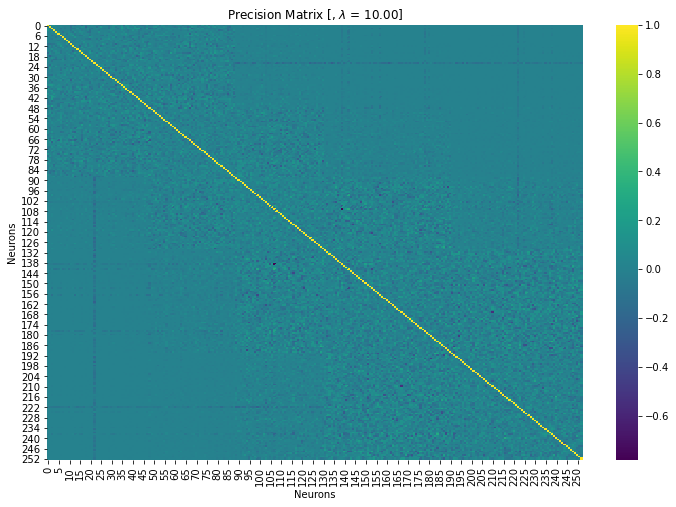

In [59]:
plt.figure(figsize = (12,8))
plot_utils.plot_prec(glasso_prec, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(glasso_prec)

<Figure size 864x576 with 0 Axes>

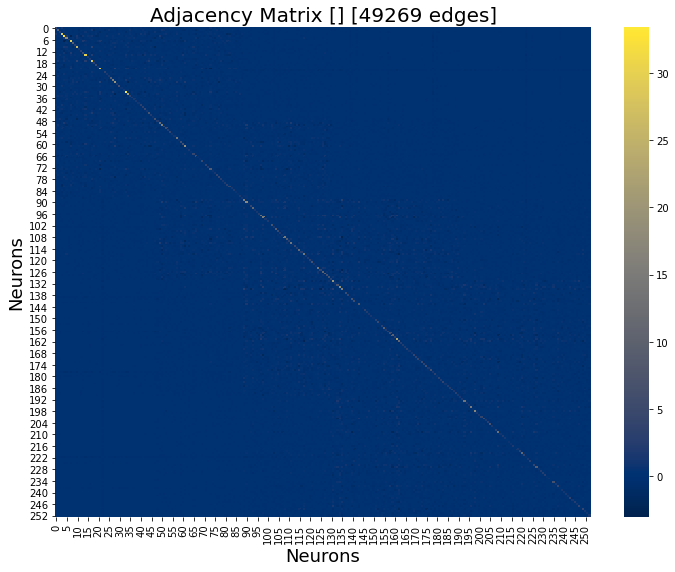

## Compare with the precision matrix for the original full data: partial_spont0


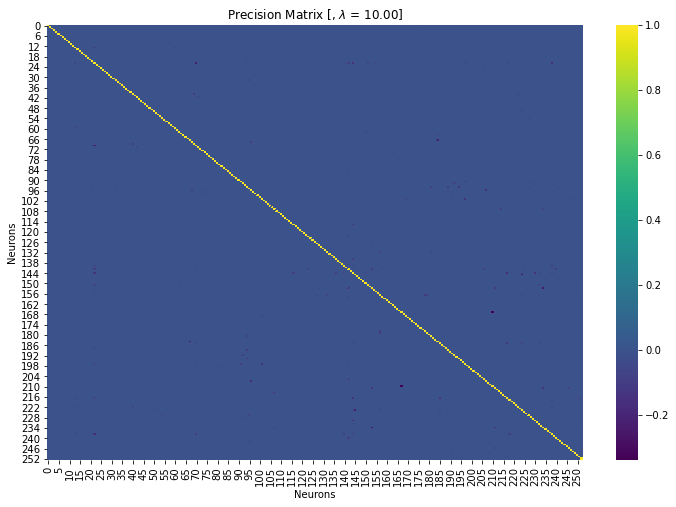

<Figure size 864x576 with 0 Axes>

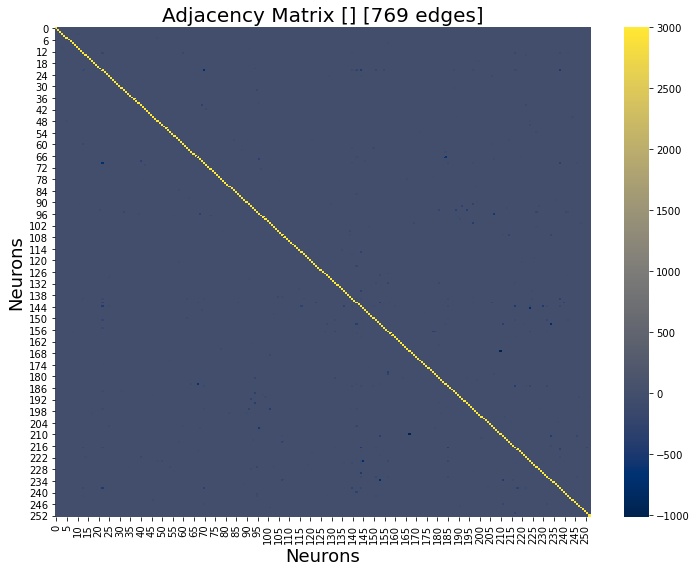

Frobenius norm of their difference: 15.93330405557069


In [82]:
prec_skggm_full = get_prec_skggm(partial_spont0.fsp, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm_full, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm_full)

diff = prec_skggm_full-glasso_prec
print("Frobenius norm of their difference:", np.linalg.norm(diff)) #Frobenius norm of the 252*253 matrix

# Approach 2 - B. Sample Missing Data by Layers (interleaving)


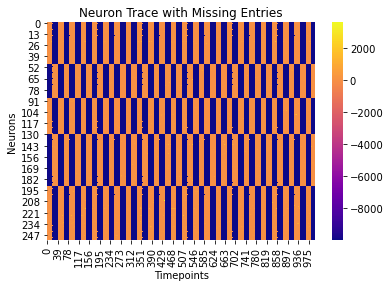

(253, 1000)


array([[ 36.80633163,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  6.84207964,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       ...,
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        ,   0.        ,   0.        , ...,          nan,
                 nan,          nan],
       [  0.        , 241.75901794,   0.        , ...,          nan,
                 nan,          nan]])

In [85]:
sampler = MissingTraceSampler()

missing_fsp_cont = sampler.missing_fsp_interleaving_layers(dataset=partial_spont0, sim_timestamps=21, 
                                                           sim_layer_size=3, display=True)

print(missing_fsp_cont.shape)
missing_fsp_cont

In [86]:
missing_fsp_cov = pd.DataFrame(missing_fsp_cont).transpose().cov()
print(missing_fsp_cov.shape)
missing_fsp_cov

(253, 253)


,0,1,2,3,4,5,6,7,8,9,...,243,244,245,246,247,248,249,250,251,252
0,1378.294222,42.512125,-58.111792,-18.508824,-2.214334,26.529550,12.208423,24.044305,52.598485,-84.438851,...,-47.557317,12.686632,30.075023,48.894862,-7.627656,196.698409,32.507400,61.627500,22.552446,-127.174772
1,42.512125,369.021112,-28.776174,13.712327,-13.877323,5.077443,10.750594,5.606100,42.579401,4.339715,...,-28.712398,69.615912,61.105575,-47.472037,-6.097904,178.549295,70.472967,57.713902,146.245673,42.951629
2,-58.111792,-28.776174,2180.831807,9.318182,3.683718,-23.340046,-130.296530,1.104077,10.669901,-43.555804,...,50.971259,29.158661,0.985822,-15.560087,86.390736,14.810998,75.888351,44.159447,66.204167,-89.199307
3,-18.508824,13.712327,9.318182,177.239391,7.344691,-12.901028,53.551283,-12.614622,-19.075137,-18.610398,...,11.521982,-73.122112,40.059620,-60.508496,3.427767,-29.633535,-23.006872,-57.771399,28.331832,13.563522
4,-2.214334,-13.877323,3.683718,7.344691,191.845722,7.072767,-42.106596,3.805030,31.372985,-33.019970,...,-28.272776,-4.694985,-14.007168,-32.286083,-34.106593,37.585613,9.125675,-32.352849,103.230176,2.380124
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,196.698409,178.549295,14.810998,-29.633535,37.585613,147.125322,-18.364215,167.263237,235.032398,-70.700778,...,194.243795,289.648498,-24.225798,451.786349,-343.207334,14888.184464,-138.895813,181.879772,365.825054,-77.988957
249,32.507400,70.472967,75.888351,-23.006872,9.125675,-19.453514,48.054877,11.720221,35.048877,113.372997,...,-174.855244,170.238807,71.423668,-114.986716,-79.412287,-138.895813,1247.828525,112.555815,151.922946,-34.536910
250,61.627500,57.713902,44.159447,-57.771399,-32.352849,-68.969900,161.352901,8.354728,-44.231182,69.701466,...,12.968024,225.145404,-179.337583,1290.952070,198.332423,181.879772,112.555815,5743.771359,-0.902234,-161.340227
251,22.552446,146.245673,66.204167,28.331832,103.230176,152.033968,-120.294626,50.747932,92.437432,-55.858996,...,106.899157,160.088888,260.913337,-49.015452,74.920926,365.825054,151.922946,-0.902234,6195.421572,103.340576


In [87]:
# For fsp of each neuron, we remove nan
temp = []
lens = []
for i, row in enumerate(missing_fsp_cont):
    row_filtered = row[np.logical_not(np.isnan(row))]
    temp.append(row_filtered)
    lens.append(len(row_filtered))

In [88]:
# Make all filtered fsp's have equal length by evenly selecting elements from them
min_len = np.min(lens)
print("min_len = ", min_len)
missing_fsp_cont_filtered = []
for row in temp:
    row_new = list(evenly_sampling(row, min_len))
    missing_fsp_cont_filtered.append(row_new)

    
missing_fsp_cont_filtered = np.array(missing_fsp_cont_filtered)
print("(missing_fsp_cont_filtered.shape = ", missing_fsp_cont_filtered.shape)

min_len =  496
(missing_fsp_cont_filtered.shape =  (253, 496)


In [89]:

# Now we use NN to predict the missing entries  in 'missing_fsp_cov'
missing_fsp_cov = np.array(missing_fsp_cov)
X = []
y = []
X_missing = [] 
Idx_missing =[]
neuron_count = len(missing_fsp_cov)

for i in range(neuron_count):
    for j in range(i, neuron_count):# total num of pairs should be: (253)*(253+1) / 2 = 32131
        f1 = missing_fsp_cont_filtered[i]
        f2 = missing_fsp_cont_filtered[j]
        if np.isnan(missing_fsp_cov[i,j]):
            X_missing.append(np.concatenate((f1,f2)))
            Idx_missing.append([i,j])
        else:
            X.append(np.concatenate((f1,f2)))
            y.append(missing_fsp_cov[i,j])
X_missing = np.array(X_missing)
Idx_missing = np.array(Idx_missing)

X = np.array(X)
y = np.array(y)

print("X_missing.shape = ", X_missing.shape)
print("Idx_missing.shape = ", Idx_missing.shape)

print("X.shape = ", X.shape)
print("y.shape = ", y.shape)

X_missing.shape =  (15300, 992)
Idx_missing.shape =  (15300, 2)
X.shape =  (16831, 992)
y.shape =  (16831,)


In [90]:
X_train, X_test, X_validation, y_train, y_test, y_validation = split_data(X, y)
print("X_train.shape = ", X_train.shape)
print("X_test.shape = ", X_test.shape)
print("X_validation.shape = ", X_validation.shape)

print("\ny_train.shape = ", y_train.shape)
print("y_test.shape = ", y_test.shape)
print("y_validation.shape = ", y_validation.shape)

X_train.shape =  (11781, 992)
X_test.shape =  (3368, 992)
X_validation.shape =  (1682, 992)

y_train.shape =  (11781,)
y_test.shape =  (3368,)
y_validation.shape =  (1682,)


In [91]:
model2 = tf.keras.Sequential([
tf.keras.layers.InputLayer(input_shape=(X_train.shape[1],)),
tf.keras.layers.Dense(256, activation='relu'),
tf.keras.layers.Dense(64, activation='relu'),
tf.keras.layers.Dense(4, activation='relu'),
tf.keras.layers.Dense(1)
])


model2.compile(optimizer='adam',     
              loss= 'mean_squared_error',  
              metrics=['mse'])

model2.fit(X_train, y_train, epochs=4, validation_data=(X_validation, y_validation))

print("\nEvaluation:")
print('test MSE:', model2.evaluate(X_test, y_test))

Epoch 1/4
369/369 [==============================] - 3s 6ms/step - loss: 4490294.1936 - mse: 4490294.1936 - val_loss: 534459.0000 - val_mse: 534459.0000
Epoch 2/4
369/369 [==============================] - 2s 5ms/step - loss: 3859640.7279 - mse: 3859640.7279 - val_loss: 534441.5000 - val_mse: 534441.5000
Epoch 3/4
369/369 [==============================] - 2s 5ms/step - loss: 3787844.6131 - mse: 3787844.6131 - val_loss: 534423.6250 - val_mse: 534423.6250
Epoch 4/4
369/369 [==============================] - 2s 5ms/step - loss: 14694926.7770 - mse: 14694926.7770 - val_loss: 534407.0625 - val_mse: 534407.0625

Evaluation:
106/106 [==============================] - 0s 2ms/step - loss: 1701724.7500 - mse: 1701724.7500
test MSE: [1701724.75, 1701724.75]


In [93]:

predict_fsp_cov = missing_fsp_cov.copy()

predictions = model2.predict(X_missing)
for k, pred in enumerate(predictions):
    i,j = Idx_missing[k]
    predict_fsp_cov[i,j] = pred
    predict_fsp_cov[j,i] = pred

predict_fsp_cov

array([[ 1.37829422e+03,  4.25121249e+01, -5.81117924e+01, ...,
         6.16275003e+01,  2.25524464e+01, -1.27174772e+02],
       [ 4.25121249e+01,  3.69021112e+02, -2.87761735e+01, ...,
         5.77139017e+01,  1.46245673e+02,  4.29516287e+01],
       [-5.81117924e+01, -2.87761735e+01,  2.18083181e+03, ...,
         4.41594468e+01,  6.62041674e+01, -8.91993071e+01],
       ...,
       [ 6.16275003e+01,  5.77139017e+01,  4.41594468e+01, ...,
         5.74377136e+03, -9.02234268e-01, -1.61340227e+02],
       [ 2.25524464e+01,  1.46245673e+02,  6.62041674e+01, ...,
        -9.02234268e-01,  6.19542157e+03,  1.03340576e+02],
       [-1.27174772e+02,  4.29516287e+01, -8.91993071e+01, ...,
        -1.61340227e+02,  1.03340576e+02,  3.29733818e+03]])

#### Now use skggm to calculate the precision matrix from the predicted covariance matrix:



In [94]:
predict_fsp_cov_PSD = sm.stats.correlation_tools.cov_nearest(predict_fsp_cov)
print(utils.isPSD(predict_fsp_cov_PSD))

True


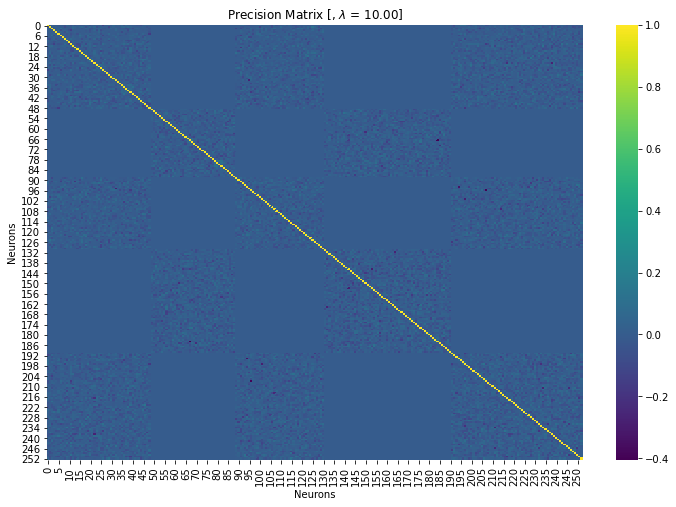

<Figure size 864x576 with 0 Axes>

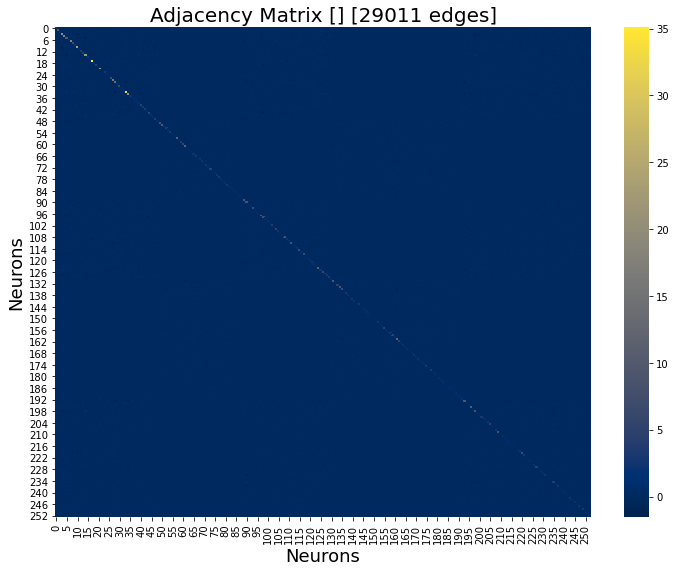

In [95]:
glasso_cov, glasso_prec = graphical_lasso(np.array(predict_fsp_cov_PSD), alpha=10)
plt.figure(figsize = (12,8))
plot_utils.plot_prec(glasso_prec, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(glasso_prec)

## Compare with the precision matrix for the original full data: partial_spont0


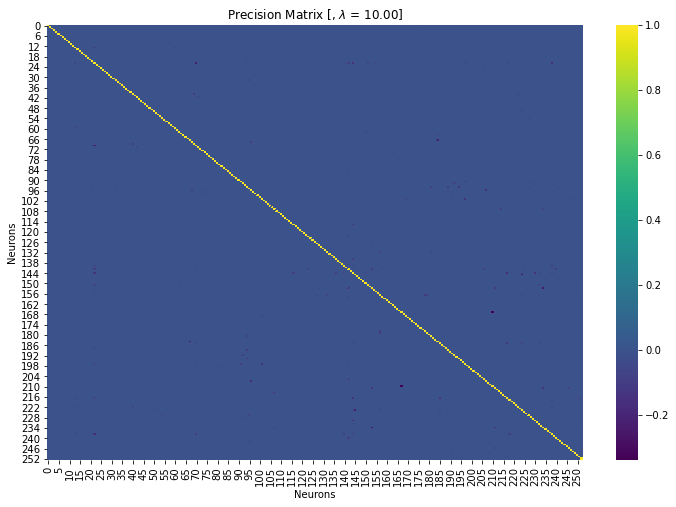

<Figure size 864x576 with 0 Axes>

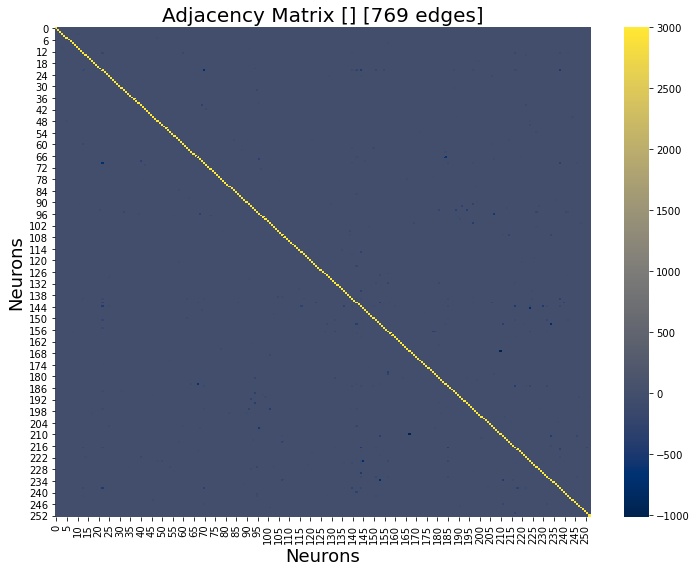

Frobenius norm of their difference: 15.94267061332878


In [96]:

prec_skggm_full = get_prec_skggm(partial_spont0.fsp, display=False)

plt.figure(figsize = (12,8))
plot_utils.plot_prec(prec_skggm_full, alpha = 10)

plt.figure(figsize = (12,8))
plot_utils.plot_adj_mat(prec_skggm_full)

diff = prec_skggm_full-glasso_prec
print("Frobenius norm of their difference:", np.linalg.norm(diff)) #Frobenius norm of the 252*253 matrix